In [1]:
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN
import pysap
from pysap.data import get_sample_data
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from modopt.math.metrics import ssim
import matplotlib.pyplot as plt
import numpy as np

/home/guillaume/temp/pysap-mri/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/guillaume/temp/pysap-mri/mri/operators/fourier/non_cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
# Lower level imports
from algo.prox import prox_G,prox_F1_dual,prox_F2_dual
from algo.pdhg import pdhg
from algo.cost_utils import *

#Upper level imports
from scipy.sparse.linalg import cg,LinearOperator
import scipy

In [3]:
u0 = get_sample_data('2d-mri')
u0_mat = u0.data

n=512
x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,u0.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')

y = (1+0j)*fourier_op.op(np.real(u0_mat))+1e-6*np.random.randn(2*n*n).view(np.complex128)

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [4]:
#Subsampling: From pysap radial mask 
radial_mask = get_sample_data("mri-radial-samples")
radial_kspace_loc = radial_mask.data
p = np.zeros((n*n+1,))

ind1 = ((n-1)*(radial_kspace_loc[:,0]+0.5)).astype(int)
ind2 = ((n-1)*(radial_kspace_loc[:,1]+0.5)).astype(int)
p[n*ind1+ind2]=1
p[-1]=1e-6

#Wavelet
linear_op = WaveletN(wavelet_name="sym8",nb_scale=4,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

# Definition of functions
Only for one linear operator for the moment (wavelet).

In [5]:
param = {"zeta":1e15,"pn1":p[-1],"epsilon":1e-5,"gamma":1e-10}

#Definition of phi=rho'(x)/x and psi=phi'(x)/x
def rho(x):
    if x<-param["gamma"]:return -x-param["gamma"]/3
    elif x<0:return x**3/3/param["gamma"]**2+x**2/param["gamma"]
    elif x<param["gamma"]:return -x**3/param["gamma"]**2/3+x**2/param["gamma"]
    else:return x-param["gamma"]/3
    
def phi(x):
    if x<-param["gamma"]:return -1/x
    elif x<0:return x/param["gamma"]**2+2/param["gamma"]
    elif x<param["gamma"]:return -x/param["gamma"]**2+2/param["gamma"]
    else:return 1/x

def psi(x):
    x=abs(x)
    if x<param["gamma"]:return -1/param["gamma"]**2/x
    else:return -1/x**3


def rho_vec(x):
    x = np.abs(x)
    return np.where(x<param["gamma"],-x**3/3/param["gamma"]**2+x**2/param["gamma"],x-param["gamma"]/3)

def phi_vec(x):
    x = np.abs(x)
    return np.where(x<=param["gamma"],-x/param["gamma"]**2+2/param["gamma"],1/x)

def psi_vec(x):
    x = np.abs(x)
    return np.where(x<param["gamma"],-1/x/param["gamma"]**2,-1/x**3)

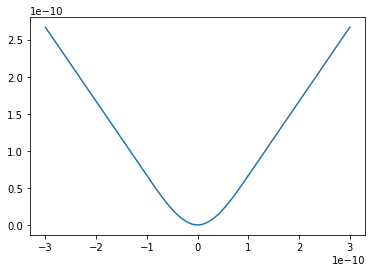

In [6]:
x = np.linspace(-3*param["gamma"],3*param["gamma"],200)
plt.plot(x,rho_vec(x))

# Functions and first order derivatives

In [7]:
from algo.cost_utils import b
#Base functions
Eeps = lambda x:param["epsilon"]/2*np.linalg.norm(x)**2
Edata = lambda x:f1(x,p[:-1],y,fourier_op)
Enonneg = lambda x:b(x,param["zeta"])
Ereg = lambda x:param["pn1"]*np.sum(rho_vec(linear_op.op(x)))
Etot = lambda x:Eeps(x)+Edata(x)+Enonneg(x)+Ereg(x)

#First order derivatives
Du_Eeps = lambda x:param["epsilon"]*x
Du_Edata = lambda x:np.real(fourier_op.adj_op(p[:-1]**2*(fourier_op.op(Rstar(x))-y)))
Du_Enonneg = lambda x:-3*param["zeta"]*np.where(x<=0,x**2,0)
Du_Ereg = lambda x:param["pn1"]*linear_op.adj_op(phi_vec(linear_op.op(x))*linear_op.op(x))
Du_Etot = lambda x:Du_Eeps(x)+Du_Edata(x)+Du_Enonneg(x)+Du_Ereg(x)

### Numerical check
Plots of $\left|\frac{f(a+th)-f(a)-<\nabla f(a),th>}{tf(a)}\right|$ for $t\rightarrow 0$. Eeps, Edata and Enonneg seem to work, but problem with Ereg.

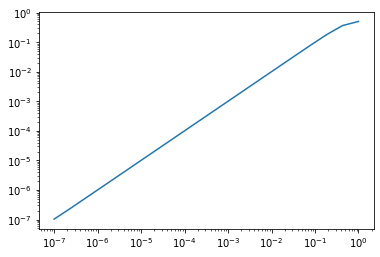

In [8]:
# -- Eeps --
#Two random vectors with same amplitude
a = np.random.randn(n**2).reshape((n,n))
a2 = np.random.randn(n**2).reshape((n,n))

tests = np.logspace(-7,0,20)
real_values = np.array([Eeps(a+t*a2) for t in tests])
approx = np.array([Eeps(a)+t*np.sum(Du_Eeps(a)*a2)for t in tests])

plt.plot(tests,(real_values-approx)/real_values/tests)
plt.xscale("log")
plt.yscale("log")

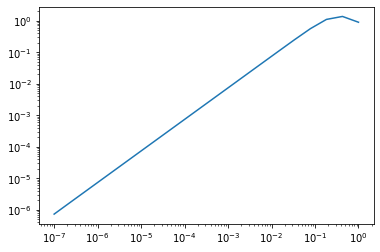

In [9]:
# -- Edata --
#Random vector with same amplitude as u0
a2 = np.random.randn(n**2).reshape((n,n))/n*np.linalg.norm(u0_mat)


tests = np.logspace(-7,0,20)
real_values = np.array([Edata(u0_mat+t*a2) for t in tests])
approx = np.array([Edata(u0_mat)+t*np.sum(Du_Edata(u0_mat)*a2)for t in tests])

plt.plot(tests,(real_values-approx)/real_values/tests)
plt.xscale("log")
plt.yscale("log")

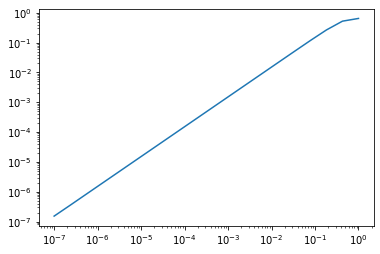

In [10]:
# -- Enonneg --
#Two random vectors with same amplitude
a = np.random.randn(n**2).reshape((n,n))
a2 = np.random.randn(n**2).reshape((n,n))

tests = np.logspace(-7,0,20)
real_values = np.array([Enonneg(a+t*a2) for t in tests])
approx = np.array([Enonneg(a)+t*np.sum(Du_Enonneg(a)*a2)for t in tests])

plt.plot(tests,(real_values-approx)/real_values/tests)
plt.xscale("log")
plt.yscale("log")

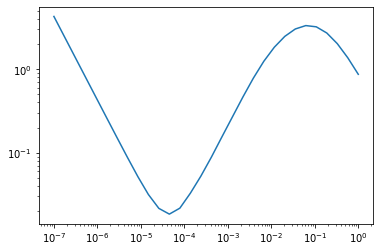

In [11]:
# -- Ereg --
#Random vector with same amplitude as u0
a2 = np.random.randn(n**2).reshape((n,n))/n*np.linalg.norm(u0_mat)

tests = np.logspace(-7,-0,30)
real_values = np.array([Ereg(u0_mat+t*a2) for t in tests])
approx = np.array([Ereg(u0_mat)+t*np.sum(Du_Ereg(u0_mat)*a2)for t in tests])

plt.plot(tests,(real_values-approx)/real_values/tests)
plt.xscale("log")
plt.yscale("log")

Gap between limits:4.7254250966540205e-14


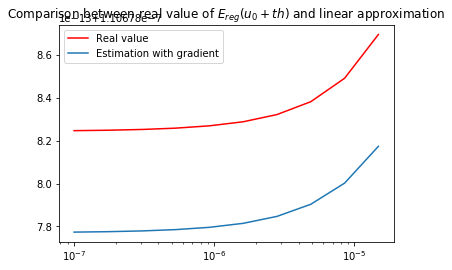

In [15]:
print(f"Gap between limits:{real_values[0]-approx[0]}")

plt.plot(tests[:10],real_values[:10],'r',label="Real value")
plt.plot(tests[:10],approx[:10],label="Estimation with gradient")
plt.xscale("log")
plt.title("Comparison between real value of $E_{reg}(u_0+th)$ and linear approximation")
plt.legend()

Always the same gap, whatever a2 (4.7254e-14) when we use u0. If we use a random a instead of u0, seems to work.

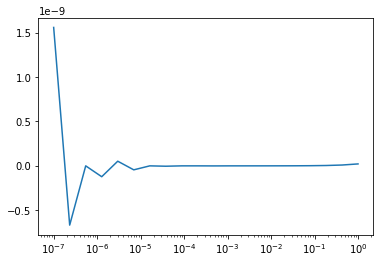

In [16]:
# -- Etot --
#Random vector with same amplitude as u0
a2 = np.random.randn(n**2).reshape((n,n))/n*np.linalg.norm(u0_mat)

tests = np.logspace(-7,0,20)
real_values = np.array([Etot(a+t*a2) for t in tests])
approx = np.array([Etot(a)+t*np.sum(Du_Etot(a)*a2)for t in tests])

plt.plot(tests,(real_values-approx)/real_values/tests)
plt.xscale("log")

# Second order derivatives
We don't express the hessians as matrices but as linear operators. Same verifications: $\frac{||\nabla f(a+th)-(\nabla f(a)+t\nabla^2f(a)h)||_2}{||\nabla f(a)||_2}$.

In [17]:
def Du2_Eeps(u,p,w):return param["epsilon"]*w
def Du2_Edata(u,p,w):return np.real(fourier_op.adj_op(p[:-1]**2*fourier_op.op(w)))
def Du2_Enonneg(u,p,w):return -6*param["zeta"]*np.where(u<0,u,0)*w
def Du2_Ereg(u,p,w):
    lin_u = linear_op.op(u)
    lin_w = linear_op.op(w)
    psi_Au = psi_vec(lin_u)
    return linear_op.adj_op(lin_u**2*lin_w*psi_Au)
def Du2_Etot(u,p,w):return Du2_Eeps(u,p,w)+Du2_Edata(u,p,w)+Du2_Enonneg(u,p,w)+Du2_Ereg(u,p,w)

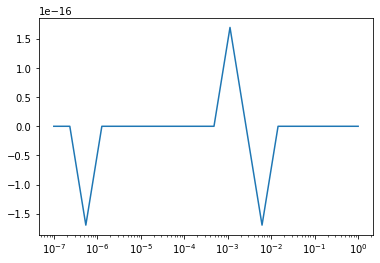

In [18]:
# -- Eeps --
#Two random vectors with same amplitude
a = np.random.randn(n**2).reshape((n,n))
a2 = np.random.randn(n**2).reshape((n,n))

tests = np.logspace(-7,0,20)
real_values = np.array([np.linalg.norm(Du_Eeps(a+t*a2)) for t in tests])
approx = np.array([np.linalg.norm(Du_Eeps(a)+Du2_Eeps(a,p,t*a2)) for t in tests])

plt.plot(tests,(real_values-approx)/real_values)
#plt.plot(tests,vals2,'r')
plt.xscale("log")

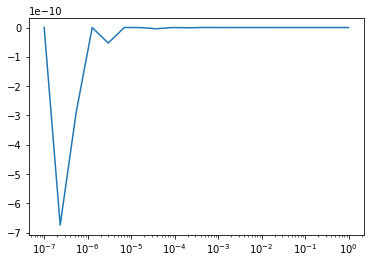

In [19]:
# -- Edata --
#Random vector with same amplitude as u0
a2 = np.random.randn(n**2).reshape((n,n))/n*np.linalg.norm(u0_mat)

tests = np.logspace(-7,0,20)
real_values = np.array([np.linalg.norm(Du_Edata(u0_mat+t*a2)) for t in tests])
approx = np.array([np.linalg.norm(Du_Edata(u0_mat)+Du2_Edata(u0_mat,p,t*a2)) for t in tests])

plt.plot(tests,(real_values-approx)/real_values/tests)
plt.xscale("log")

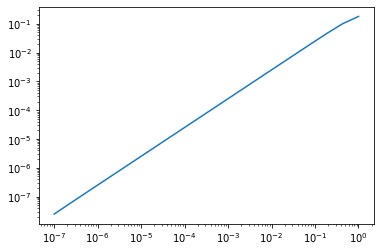

In [20]:
# -- nonneg --
#Two random vectors with same amplitude
a = np.random.randn(n**2).reshape((n,n))-0.5
a2 = np.random.randn(n**2).reshape((n,n))

tests = np.logspace(-7,0,20)
real_values = np.array([np.linalg.norm(Du_Enonneg(a+t*a2)) for t in tests])
approx = np.array([np.linalg.norm(Du_Enonneg(a)+Du2_Enonneg(a,p,t*a2)) for t in tests])

plt.plot(tests,(real_values-approx)/real_values/tests)
plt.xscale("log")
plt.yscale("log")

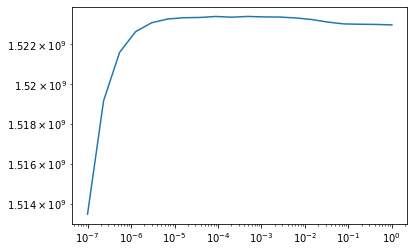

In [21]:
# -- Ereg --
#Random vector with same amplitude as u0
a2 = np.random.randn(n**2).reshape((n,n))/n*np.linalg.norm(u0_mat)

tests = np.logspace(-7,0,20)
real_values = np.array([np.linalg.norm(Du_Ereg(u0_mat+t*a2)) for t in tests])
approx = np.array([np.linalg.norm(Du_Ereg(u0_mat)+Du2_Ereg(u0_mat,p,t*a2)) for t in tests])

plt.plot(tests,abs((real_values-approx)/real_values/tests))
plt.xscale("log")
plt.yscale("log")

In [22]:
def Dpu_Edata(u,p,w):
    Fu = np.conj(fourier_op.op(Rstar(u))-y)
    Fw = fourier_op.op(w)
    return 2*np.real(p[:-1]*Fu*Fw)
def Dpu_Ereg(u,p,w):
    return np.sum(w*linear_op.adj_op(phi_vec(linear_op.op(u))*linear_op.op(u)))

def Dpu_Etot(u,p,w):
    g = np.zeros((n**2+1,))
    g[:-1] = Dpu_Edata(u,p,w)
    g[-1] = Dpu_Ereg(u,p,w)
    return g

## Loss function and penalty

In [76]:
c = 1e0
def L(u,u2):return c*np.linalg.norm(u-u2)**2
def grad_L(u,u2):return 2*c*(u-u2)

beta = 1e-10*c
def P(p):return beta*np.sum(p[:-1]*(2-p[:-1]))
def grad_P(p):
    Dp = 2*(1-p)
    #Don't change alpha
    Dp[-1] = 0
    return beta*Dp
# P = lambda x:beta*np.linalg.norm(p)**2
# grad_P = lambda x:2*beta*x

In [75]:
param["pn1"]=1e-6
uk,norms,energy = pdhg(y,p[:-1],fourier_op,linear_op,param,maxit=20,verbose=0)
print(f"L(u(p))={L(uk,u0_mat)}\nP(p)={P(p)}")

Finished in 9.710845708847046 seconds.
L(u(p))=8.29182311459582e-08
P(p)=2.9767e-07


In [79]:
print(np.linalg.norm(grad_L(uk,u0_mat)),np.linalg.norm(grad_P(0.9*p[:-1])))

0.000575910517861788 9.647251836663137e-08


# Upper level energy

In [111]:
uk = np.zeros(u0_mat.shape)

def E(pk):
    global uk
    print("\nEvaluating E(p)")
    param["pn1"]=pk[-1]
    uk,norms = pdhg(y,pk[:-1],fourier_op,linear_op,param,compute_energy=False,maxit=20,verbose=0)
    return L(uk,u0_mat)+P(pk)

cgconv = []
def grad_E(pk):
    global uk,cgconv
    #Update alpha(p)
    param["pn1"]=pk[-1]
    
    print("\nStarting PDHG")
    uk,norms = pdhg(y,pk[:-1],fourier_op,linear_op,param,compute_energy=False,maxit=20,verbose=0)
    
    def mv(w):
        w = np.reshape(w,(n,n))
        return np.reshape(Du2_Etot(uk,pk,w),(n**2,))
    
    
    # -- Use cg to compute gradient --
    lin = LinearOperator((n**2,n**2),matvec=mv)
    B = np.reshape(grad_L(uk,u0_mat),(n**2,))
    def cgcall(x):
        cgconv.append(np.linalg.norm(lin(x)-B)/np.linalg.norm(B))
    
    print("\nStarting Conjugate Gradient method")
    x_inter,convergence = cg(lin,B,tol=1e-4,maxiter=500,callback=cgcall)
    print(f"||Ax-b||/||b||: {np.linalg.norm(lin(x_inter)-B)/np.linalg.norm(B)}")
    return Dpu_Etot(uk,pk,np.reshape(x_inter,(n,n)))+grad_P(pk)

# Callback function
niter = 0
def fcall(x):
    global uk,niter
    niter += 1
    print("\033[1m" + f"\n{niter} iterations: ssim={ssim(uk,u0_mat)}\n\n" + "\033[0m")

In [95]:
p0 = np.random.rand(n**2+1)
Ep0,gradEp0 = E(p0),grad_E(p0)
p1 = np.random.rand(n**2+1)

tests = np.logspace(-7,0,20)
real_values = np.array([E(p0+t*p1) for t in tests])
approx = np.array([Ep0+t*np.sum(gradEp0*p1) for t in tests])


Evaluating E(p)
Finished in 6.5491344928741455 seconds.

Starting PDHG
Finished in 8.215799570083618 seconds.

Starting Conjugate Gradient method
0.02854429927731948

Evaluating E(p)
Finished in 12.732693195343018 seconds.

Evaluating E(p)
Finished in 12.910942554473877 seconds.

Evaluating E(p)
Finished in 11.156272172927856 seconds.

Evaluating E(p)
Finished in 12.606735944747925 seconds.

Evaluating E(p)
Finished in 13.371719598770142 seconds.

Evaluating E(p)
Finished in 11.73125171661377 seconds.

Evaluating E(p)
Finished in 12.508919477462769 seconds.

Evaluating E(p)
Finished in 12.782058477401733 seconds.

Evaluating E(p)
Finished in 13.059777736663818 seconds.

Evaluating E(p)
Finished in 13.279117584228516 seconds.

Evaluating E(p)
Finished in 13.307068586349487 seconds.

Evaluating E(p)
Finished in 13.270675420761108 seconds.

Evaluating E(p)
Finished in 13.066627502441406 seconds.

Evaluating E(p)
Finished in 13.328679084777832 seconds.

Evaluating E(p)
Finished in 13.5726

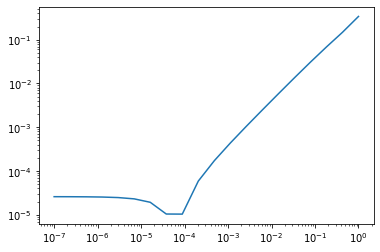

In [96]:
plt.plot(tests,abs((real_values-approx)/real_values/tests))
plt.xscale("log")
plt.yscale("log")

In [112]:
gP = grad_E(p0)


Starting PDHG
Finished in 6.6991472244262695 seconds.

Starting Conjugate Gradient method
||Ax-b||/||b||: 2.428940292256567


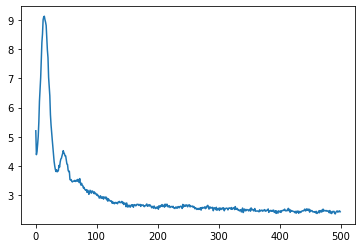

In [113]:
plt.plot(cgconv)

In [85]:
print(np.linalg.norm(grad_P(p0)),np.linalg.norm(gP))

9.166319429510973e-08 9.278136861609869e-08


# L-BFGS-B

In [97]:
p0 = 0.9*p+0.1*np.random.rand(n**2+1)
#p0 = np.random.rand(n**2+1)
p0=np.ones(n**2+1)
p0[-1] = 1e-6

niter = 0
res = scipy.optimize.minimize(E,p0,method='L-BFGS-B',jac=grad_E
                              ,bounds=[(0,1)]*n**2+[(0,np.inf)]
                              ,callback=fcall
                              ,options={'gtol':1e-15,'maxiter':4,'maxfun':4})


Evaluating E(p)
Finished in 7.7304511070251465 seconds.

Starting PDHG
Finished in 14.58654522895813 seconds.

Starting Conjugate Gradient method
3.0410419634114763

Evaluating E(p)
Finished in 13.677726745605469 seconds.

Starting PDHG
Finished in 13.474161386489868 seconds.

Starting Conjugate Gradient method
3.119374804908969

1 iterations: ssim=0.9176162107056209




In [98]:
pf = res.x
print(E(p0),E(pf))


Evaluating E(p)
Finished in 8.028401136398315 seconds.

Evaluating E(p)
Finished in 7.511856555938721 seconds.
2.6269265797045295e-05 2.6267675084055204e-05


In [99]:
print(pf[-1])
pysap.Image(data=np.reshape(pf[:-1],(n,n))).show()

1.044576172541336e-06


/home/guillaume/anaconda3/lib/python3.7/site-packages/pyqtgraph/functions.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  data = rescaleData(data, scale/(maxVal-minVal), minVal, dtype=dtype)
/home/guillaume/anaconda3/lib/python3.7/site-packages/pyqtgraph/functions.py:870: RuntimeWarning: invalid value encountered in multiply
  d2 *= scale


10  iterations:
Cost: 8.772578054456486e-08 
Norm: 0.07050469994161677 

20  iterations:
Cost: 8.429884305595803e-08 
Norm: 0.006174075634777439 

30  iterations:
Cost: 8.385403999321318e-08 
Norm: 0.0015817253406313408 

40  iterations:
Cost: 8.376926936833475e-08 
Norm: 0.0007687368822694923 

50  iterations:
Cost: 8.374813239832085e-08 
Norm: 0.0005397526683627604 

60  iterations:
Cost: 8.373893173324553e-08 
Norm: 0.0004308719958126561 

70  iterations:
Cost: 8.373347463428974e-08 
Norm: 0.00035569521872293327 

80  iterations:
Cost: 8.37292153760354e-08 
Norm: 0.00030676387099849137 

90  iterations:
Cost: 8.372661939592902e-08 
Norm: 0.0002740064426511952 

100  iterations:
Cost: 8.372482124121226e-08 
Norm: 0.0002488539777065706 

Finished in 55.96584486961365 seconds.
0.9194274622137819


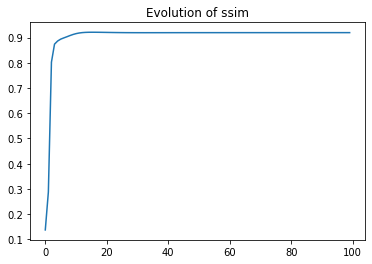

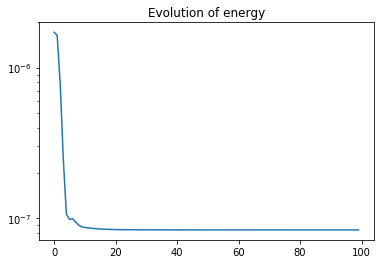

In [89]:
uk,norms,energy,ssims = pdhg(y,pf[:-1],fourier_op,linear_op,param,real_image=u0_mat,maxit=100)
print(ssim(uk,u0_mat))

plt.figure()
plt.plot(ssims)
plt.title("Evolution of ssim")
plt.show()

plt.figure()
plt.plot(energy)
plt.title("Evolution of energy")
plt.yscale("log")
plt.show()

pysap.Image(data=uk).show()